# Comparison of DFT/MD/CSC real space LB at 7.34 deg
Part 1: real space

In [113]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.linalg as LA
from scipy import interpolate
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
spectral = cm.get_cmap('Spectral', 45)
spectral_l = spectral(range(45))

my_map = ListedColormap(spectral_l[5:40])
FONT_SIZE = 28

## MD

In [114]:
# Load the displacements, indexed by atomic index
data = np.loadtxt('/Users/jonathanlu/Documents/tvGr/MD/rs12.txt')
npts = data.shape[0] // 6

x = []
y = []
z = []
for i, datum in enumerate(data):
    idx = (i % 3)
    if idx == 0:
        x.append(datum)
    elif idx == 1:
        y.append(datum)
    elif idx == 2:
        z.append(datum)
x = np.array(x)
y = np.array(y)
z = np.array(z) * np.sqrt(244)

x1 = []
x2 = []
y1 = []
y2 = []
z1 = []
z2 = []

for i, datum in enumerate(data):
    idx = (i % 6)
    
    if idx == 0:
        x1.append(datum)
    elif idx == 1:
        y1.append(datum)
    elif idx == 2:
        z1.append(datum)
    elif idx == 3:
        x2.append(datum)
    elif idx == 4:
        y2.append(datum)
    elif idx == 5:
        z2.append(datum)
        
x1 = np.array(x1)
y1 = np.array(y1)
z1 = np.array(z1) * np.sqrt(244)
x2 = np.array(x2)
y2 = np.array(x2)
z2 = np.array(x2) * np.sqrt(244)
print(x.shape)

(244,)


In [115]:
# Load the equilibrium positions and atomic indices
a = np.loadtxt('/Users/jonathanlu/Documents/tvGr/MD/input_position.dat')[:,:-3]

# Reorder by atomic index
a = a[a[:, 0].argsort()]
coords = a[:,[0,4,5,6]]
layer_1 = (coords[:,-1] < 0)
layer_2 = (coords[:,-1] > 0)
cx = coords[:,1]
cy = coords[:,2]
cxy = coords[:,1:-1]
cz = coords[:,3]

coords1 = []
coords2 = []
for pt in a:
    if pt[-1] < 0:
        coords1.append(pt[-3:-1])
    elif pt[-1] > 0:
        coords2.append(pt[-3:-1])
        
coords1 = np.array(coords1)
coords2 = np.array(coords2)

In [116]:
# Compute the moire lattice constant
lc = np.max(cx)
A = lc * np.array([[1,-1/2],[0,np.sqrt(3)/2]]).T

# Sample a mesh grid
line = np.linspace(0, 1-1/13, 13)
from itertools import product as prod
grid = np.array(list(prod(line, line)))
mesh = grid @ A

x1 = interpolate.griddata(cxy[layer_1], x[layer_1], mesh)
y1 = interpolate.griddata(cxy[layer_1], y[layer_1], mesh)
x2 = interpolate.griddata(cxy[layer_2], x[layer_2], mesh)
y2 = interpolate.griddata(cxy[layer_2], y[layer_2], mesh)

phi1 = np.pi / 50
R1 = np.array([[np.cos(phi1), np.sin(phi1)],[-np.sin(phi1), np.cos(phi1)]])
rcxy1 = cxy @ R1
cx1 = rcxy1[:,0] 
cy1 = rcxy1[:,1] 

phi2 = -np.pi / 40
R2 = np.array([[np.cos(phi2), np.sin(phi2)],[-np.sin(phi2), np.cos(phi2)]])
rcxy2 = cxy @ R2
cx2 = rcxy2[:,0] 
cy2 = rcxy2[:,1] 

cx1[layer_1] += 0.8
cx1[layer_1] *= 19.26788 / np.max(cx1[layer_1])
cy1[layer_1] -= 1.2
cy1[layer_1] *= 16.68648 / np.max(cy1[layer_1])
cx2[layer_2] -= 1.3
cx2[layer_2] *= 19.26788 / np.max(cx2[layer_2])
cy2[layer_2] *= 16.68648 / np.max(cy2[layer_2])

mesh[:,0] *= 19.26788 / np.max(mesh[:,0])
mesh[:,1] *= 16.68648 / np.max(mesh[:,1])

In [117]:
import numpy.linalg as LA
f1 = np.logical_not(np.isnan(x1))
f2 = np.logical_not(np.isnan(x2))
mean_xy1 = np.mean(LA.norm(np.array([x1, y1])[:,f1], axis=0)) * np.sqrt(244)
mean_xy2 = np.mean(LA.norm(np.array([x2, y2])[:,f2], axis=0)) * np.sqrt(244)
mean_z1 = np.mean(np.abs(z[layer_1])) 
mean_z2 = np.mean(np.abs(z[layer_2])) 
print(f"Layer 1: mean xy = {mean_xy1}, mean z = {mean_z1}")
print(f"Layer 2: mean xy = {mean_xy2}, mean z = {mean_z2}")

Layer 1: mean xy = 0.022060246372437798, mean z = 0.9994246768008248
Layer 2: mean xy = 0.02206024521372393, mean z = 0.9994246767168119


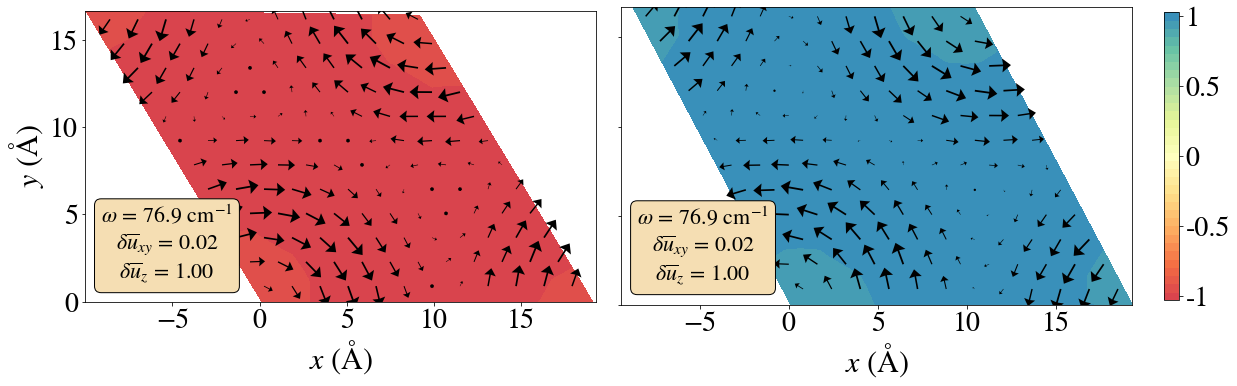

In [131]:
fig, (ax2, ax) = plt.subplots(ncols=2, figsize=(18,6), 
                              gridspec_kw={'width_ratios': [0.8, 1]},
                              sharey=True)
CMAP = my_map # 'coolwarm'

# make the default Font latex
plt.rc('font', size=20)
minz, maxz = np.floor(np.min(z)*100)/100, np.ceil(np.max(z)*100)/100
n = len(coords1)
dd_factor = 1
dd = np.arange(n//dd_factor)*dd_factor


tcf = ax.tricontourf(cx1[layer_1], cy1[layer_1], z[layer_1], 
                     cmap=CMAP, levels=np.linspace(minz, maxz, 501), vmin=np.min(z), vmax=np.max(z))
cbar_l = [-1, -0.5, 0, 0.5, 1]
cbar = plt.colorbar(tcf, shrink=0.8, ticks=cbar_l)
cbar.ax.set_yticklabels(cbar_l, fontsize=FONT_SIZE)
ax.quiver(mesh[:,0], mesh[:,1] - 0.5,    # positions
            -x1, -y1, 
            width=0.005, minshaft=2.5, headwidth=8, scale=0.05, color='black') # arrows
ax.set_ylim(bottom=0, top=np.max(cy1[layer_1]))
ax2.set_xlim(left=-10, right=19.3)
ax2.set_ylim(bottom=0, top=np.max(cy2[layer_2]))
ax.set_xlim(left=-9.39747)

tcf2 = ax2.tricontourf(cx2[layer_2], cy2[layer_2], z[layer_2], 
                cmap=CMAP, levels=501, vmin=np.min(z), vmax=np.max(z))
ax2.quiver(mesh[:,0] - 0.55, mesh[:,1] - 0.5,    # positions
            -x2, -y2, 
            width=0.008, minshaft=2.5, headwidth=8, scale=0.05, color='black') # arrows

ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_aspect('equal')
ax2.set_ylabel(r"$y$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax2.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax2.tick_params(axis='both', labelsize=FONT_SIZE)
ax2.set_aspect('equal')

FREQ = 76.88
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

textstr_1 = r'$\omega \,=\, %.1f$ cm$^{-1}$'%FREQ + '\n' + \
            r'$\delta \overline{u}_{xy} \,=\, 0.02$' + \
            '\n' + r'$\delta \overline{u}_{z} \,%s\, %.2f$'%("=", round(mean_z1, 2))
textstr_2 = r'$\omega \,=\, %.1f$ cm$^{-1}$'%FREQ + '\n' + \
            r'$\delta \overline{u}_{xy} \,=\, 0.02$' + \
            '\n' + r'$\delta \overline{u}_{z} \,%s\, %.2f$'%("=", round(mean_z2, 2))
# ax.text(0.16, 0.21, textstr_1, 
#         transform=ax.transAxes, verticalalignment='center', 
#         horizontalalignment='center', bbox=props, 
#         fontsize=22)
# ax2.text(0.16, 0.21, textstr_2, 
#         transform=ax2.transAxes, verticalalignment='center', 
#         horizontalalignment='center', bbox=props, 
#         fontsize=22)
ax.text(0.16, 0.195, textstr_1, 
        transform=ax.transAxes, verticalalignment='center', 
        horizontalalignment='center', bbox=props, 
        fontsize=22)
ax2.text(0.16, 0.195, textstr_2, 
        transform=ax2.transAxes, verticalalignment='center', 
        horizontalalignment='center', bbox=props, 
        fontsize=22)
ax.set_aspect('equal')
ax2.set_aspect('equal')
ax.set_xticks([-5, 0, 5, 10, 15])
ax2.set_xticks([-5, 0, 5, 10, 15])
ax2.set_yticks([0, 5, 10, 15])
ax2.set_yticklabels([0,5,10,15])

plt.tight_layout()
plt.savefig("/Users/jonathanlu/Documents/data_mlph/MD_7.34_12.png")

## CSC

In [96]:
from pymatgen.io.vasp.inputs import Poscar
ROOT = '/Users/jonathanlu/Documents'
DIRNAME = "tvGr"
n_at = 4
THSPC_DIR = "theta"
SAVE_LB = True
LABELY = True

th_min, th_max, ntheta = np.loadtxt(f"{ROOT}/{DIRNAME}/theta.txt")
ntheta = int(ntheta)
KPT = 'Gamma'
print(f"{ntheta} angles from {th_min} to {th_max}")

# Import dataset from the directory
log_name = r'$\Gamma$' if KPT == 'Gamma' else KPT
path = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_mags.npy'
ppath = f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_phonons.npy'
poscars_uc = [Poscar.from_file(f'{ROOT}/{DIRNAME}/POSCAR_LAYER{i+1}') for i in range(2)]
dataset = np.load(path)
phonons = np.load(ppath)
nmodes = dataset.shape[1]
print("Dataset shape:", dataset.shape)
print("Number of modes:", nmodes)
thetas = np.linspace(th_min, th_max, ntheta)

DMs = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/dms.npy')
GM_set = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/GM_set.npy')
k_set = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/k_set.npy')
bl_M = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/masses.npy')
mesh = np.load(f'{ROOT}/{DIRNAME}/{THSPC_DIR}/{KPT}/thspc_mesh.npy')
print(f"Mesh shape: {mesh.shape}")
print(f"K-point: {KPT}")

101 angles from 0.01 to 10.0
Dataset shape: (101, 61, 1521, 3)
Number of modes: 61
Mesh shape: (101, 1521, 2)
K-point: Gamma


Analyzing theta = 7.3027 (idx=73)


<Figure size 432x288 with 0 Axes>

/Users/jonathanlu/miniconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/jonathanlu/miniconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


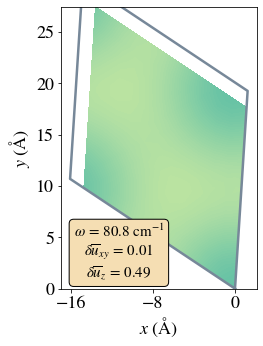

<Figure size 432x288 with 0 Axes>

/Users/jonathanlu/miniconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/jonathanlu/miniconda3/lib/python3.7/site-packages/matplotlib/quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


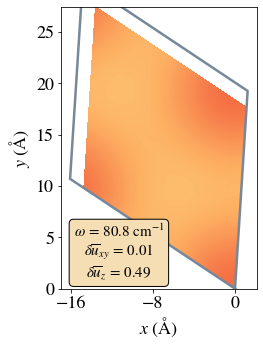

In [108]:
# Visualize the real-space phonons
from __class_PhononConfig import TwistedRealspacePhonon
THETA_IDX = 73
WHICH_MODE = 11
print(f"Analyzing theta = {thetas[THETA_IDX]} (idx={THETA_IDX})")
coords = mesh[THETA_IDX]

# k_set[THETA_IDX] = GM_set[THETA_IDX][:2]

ph = TwistedRealspacePhonon(thetas[THETA_IDX], k_set[THETA_IDX], 
                            GM_set[THETA_IDX], DMs[THETA_IDX], n_at, 
                            bl_M, poscars_uc, modeidxs=np.arange(nmodes),
                            rspc_sc_sz=1, gridsz=12, 
                            outdir=f'{ROOT}/data_mlph')
coords, phonons = ph.plot_a_phonon(WHICH_MODE, save=False, outname='T.png', rectangular=False, 
                 ticky=True, labely=LABELY, labelx=True, reduce_tick=True,
                 shift=0.01)
sc_l = ph.sc_lattice

In [109]:
phi1 = -np.pi / 50 - np.pi/2

R1 = np.array([[np.cos(phi1), np.sin(phi1)],[-np.sin(phi1), np.cos(phi1)]])
coords = coords @ R1.T
coords[:,0] *= -1
coords[:,0] += -10
coords[:,1] += np.abs(np.min(coords[:,1]))

L1, L2 = phonons
L1[:,:-1] = L1[:,:-1] @ R1.T
L2[:,:-1] = L2[:,:-1] @ R1.T
L1[:,0] *= -1
L2[:,0] *= -1

coords[:,0] += 1.3
coords[:,0] *= 19.26788 / np.max(coords[:,0])
coords[:,1] *= 16.68648 / np.max(coords[:,1])
# L1[:,-1] *= np.sqrt(144)
# L2[:,-1] *= np.sqrt(144)
val = 1/np.max(np.abs(L1[:,-1]))
print(val)
L1[:,-1] *= val
L2[:,-1] *= val

1.4510674922174354


In [110]:
import numpy.linalg as LA
mean_xy1 = np.mean(LA.norm(L1[:,:-1], axis=0)) * val
mean_xy2 = np.mean(LA.norm(L2[:,:-1], axis=0)) * val
mean_z1 = np.mean(np.abs(L1[:,-1])) 
mean_z2 = np.mean(np.abs(L2[:,-1])) 
print(f"Layer 1: mean xy = {mean_xy1}, mean z = {mean_z1}")
print(f"Layer 2: mean xy = {mean_xy2}, mean z = {mean_z2}")

Layer 1: mean xy = 0.0828165562962886, mean z = 0.7163841434522544
Layer 2: mean xy = 0.08280443832174238, mean z = 0.7155705487594426


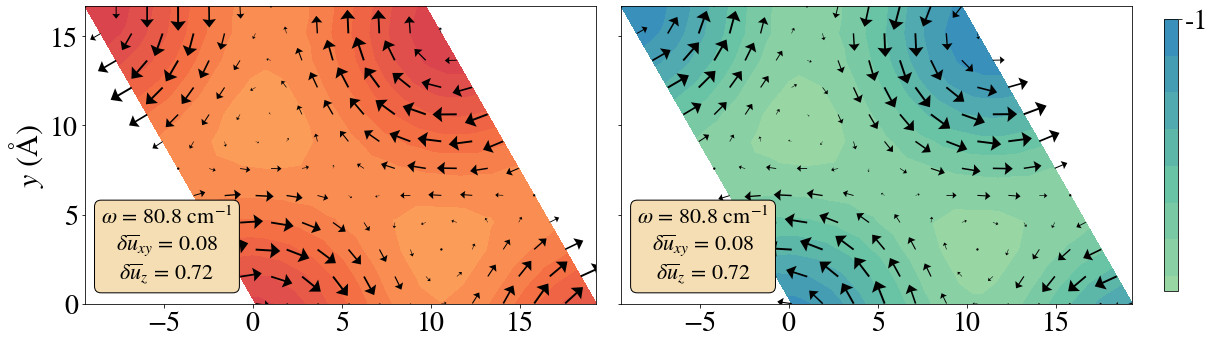

In [111]:
fig, (ax2, ax) = plt.subplots(ncols=2, figsize=(18,6), 
                              gridspec_kw={'width_ratios': [0.8, 1]},
                              sharey=True)
CMAP = my_map # 'coolwarm'

# make the default Font latex
plt.rc('font', size=20)
z = phonons[:,:,-1]
minz, maxz = np.floor(np.min(z)*100)/100, np.ceil(np.max(z)*100)/100

tcf = ax.tricontourf(coords[:,0], coords[:,1], L1[:,-1], 
                     cmap=CMAP, levels=501, vmin=np.min(z), vmax=np.max(z))
ax.quiver(coords[:,0], coords[:,1],    # positions
            L1[:,0], L1[:,1], 
            width=0.005, minshaft=2.5, headwidth=8, scale=0.2, color='black') # arrows
# ax.set_ylim(bottom=0, top=16)

tcf2 = ax2.tricontourf(coords[:,0], coords[:,1], L2[:,-1], 
                     cmap=CMAP, levels=501, vmin=np.min(z), vmax=np.max(z))
ax2.quiver(coords[:,0], coords[:,1],    # positions
            L2[:,0], L2[:,1], 
            width=0.005, minshaft=2.5, headwidth=8, scale=0.2, color='black') # arrows
cbar_l = [-1, -0.5, 0, 0.5, 1]
cbar = plt.colorbar(tcf, shrink=0.7, ticks=cbar_l)
cbar.ax.set_yticklabels(cbar_l, fontsize=FONT_SIZE)

ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax2.set_ylabel(r"$y$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
# ax.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
ax2.tick_params(axis='both', labelsize=FONT_SIZE)
# ax2.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
# ax2.set_yticklabels(ax.get_yticklabels())

FREQ = 80.8
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

textstr_1 = r'$\omega \,=\, %.1f$ cm$^{-1}$'%FREQ + '\n' + \
            r'$\delta \overline{u}_{xy} \,=\, %.2f$'%round(mean_xy1, 2) + \
            '\n' + r'$\delta \overline{u}_{z} \,%s\, %.2f$'%("=", round(mean_z1, 2))
textstr_2 = r'$\omega \,=\, %.1f$ cm$^{-1}$'%FREQ + '\n' + \
            r'$\delta \overline{u}_{xy} \,=\, %.2f$'%round(mean_xy1, 2) + \
            '\n' + r'$\delta \overline{u}_{z} \,%s\, %.2f$'%("=", round(mean_z2, 2))
ax.text(0.16, 0.195, textstr_1, 
        transform=ax.transAxes, verticalalignment='center', 
        horizontalalignment='center', bbox=props, 
        fontsize=22)
ax2.text(0.16, 0.195, textstr_2, 
        transform=ax2.transAxes, verticalalignment='center', 
        horizontalalignment='center', bbox=props, 
        fontsize=22)
ax.set_aspect('equal')
ax2.set_aspect('equal')
ax.set_xticks([-5, 0, 5, 10, 15])
ax2.set_xticks([-5, 0, 5, 10, 15])

plt.tight_layout()
plt.savefig("/Users/jonathanlu/Documents/data_mlph/CSC_7.34_11.png")

## DFT

In [92]:
dft_sc = np.array([[19.26788391,  0.        ,  0.        ],
                   [-9.6339444 , 16.68647856,  0.        ],
                   [ 0.        ,  0.        , 20.        ]])
DFT = np.loadtxt('/Users/jonathanlu/Documents/tvGr/DFT/rs.txt')
# DFT[:,3:] *= np.sqrt(122)
L1, L2 = np.split(DFT, 2, axis=0)

In [93]:
# phi1 = np.pi / 48
# R1 = np.array([[np.cos(phi1), np.sin(phi1)],[-np.sin(phi1), np.cos(phi1)]])
# L1[:,:2] = L1[:,:2] @ R1.T

# phi2 = -np.pi / 50
# R2 = np.array([[np.cos(phi2), np.sin(phi2)],[-np.sin(phi2), np.cos(phi2)]])
# L2[:,:2] = L2[:,:2] @ R2.T
# L2[:,1] -= np.min(L2[:,1])

0.0063286507425648845


(16.68648, 19.26788)

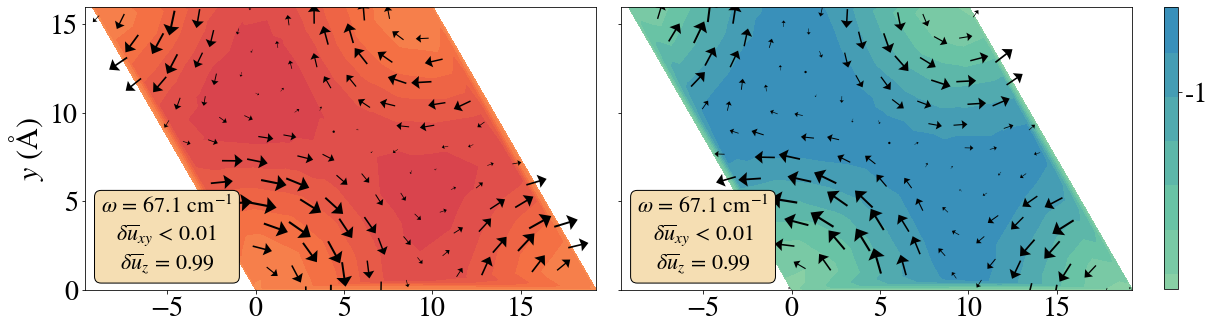

In [95]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(18,6), 
                              gridspec_kw={'width_ratios': [0.8, 1]},
                              sharey=True)
CMAP = my_map # 'coolwarm'

# make the default Font latex
plt.rc('font', size=20)
z = DFT[:,-1]* np.sqrt(244)
minz, maxz = np.floor(np.min(z)*100)/100, np.ceil(np.max(z)*100)/100

tcf = ax.tricontourf(L1[:,0], L1[:,1], L1[:,-1] * np.sqrt(244), 
                     cmap=CMAP, levels=501, vmin=np.min(z), vmax=np.max(z))
ax.quiver(L1[:,0], L1[:,1],    # positions
            L1[:,3], L1[:,4], 
            width=0.005, minshaft=2.5, headwidth=8, scale=0.014, color='black') # arrows
ax.set_ylim(bottom=0, top=16)

tcf2 = ax2.tricontourf(L2[:,0], L2[:,1], L2[:,-1] * np.sqrt(244), 
                     cmap=CMAP, levels=501, vmin=np.min(z), vmax=np.max(z))
ax2.quiver(L2[:,0], L2[:,1],    # positions
            L2[:,3], L2[:,4], 
            width=0.005, minshaft=2.5, headwidth=8, scale=0.014, color='black') # arrows

ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax2.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel(r"$y$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
# ax.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
# ax2.set_xlabel(r"$x$ ($\mathrm{\AA}$)", fontsize=FONT_SIZE+2)
# ax2.set_yticklabels(ax.get_yticklabels())

cbar_l = [-1, -0.5, 0, 0.5, 1.0]
cbar = plt.colorbar(tcf2, shrink=0.725, ticks=cbar_l)
cbar.ax.set_yticklabels(cbar_l, fontsize=FONT_SIZE)

mean_xy1 = np.mean(LA.norm(L1[:,3:5], axis=1)) * np.sqrt(244)
mean_xy2 = np.mean(LA.norm(L2[:,3:5], axis=1)) * np.sqrt(244)
mean_z1 = np.mean(np.abs(L1[:,-1])) * np.sqrt(244)
mean_z2 = np.mean(np.abs(L2[:,-1])) * np.sqrt(244)
print(mean_xy1)

FREQ = 67.1
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

textstr_1 = r'$\omega \,=\, %.1f$ cm$^{-1}$'%FREQ + '\n' + \
            r'$\delta \overline{u}_{xy} \,<\, 0.01$' + \
            '\n' + r'$\delta \overline{u}_{z} \,%s\, %.2f$'%("=", round(mean_z1, 2))
textstr_2 = r'$\omega \,=\, %.1f$ cm$^{-1}$'%FREQ + '\n' + \
            r'$\delta \overline{u}_{xy} \,<\, 0.01$' + \
            '\n' + r'$\delta \overline{u}_{z} \,%s\, %.2f$'%("=", round(mean_z2, 2))
ax.text(0.16, 0.19, textstr_1, 
        transform=ax.transAxes, verticalalignment='center', 
        horizontalalignment='center', bbox=props, 
        fontsize=22)
ax2.text(0.16, 0.19, textstr_2, 
        transform=ax2.transAxes, verticalalignment='center', 
        horizontalalignment='center', bbox=props, 
        fontsize=22)
ax.set_aspect('equal')
ax2.set_aspect('equal')
ax.set_xticks([-5, 0, 5, 10, 15])
ax2.set_xticks([-5, 0, 5, 10, 15])

plt.tight_layout()
plt.savefig("/Users/jonathanlu/Documents/data_mlph/DFT_7.34_11.png")
np.max(L2[:,1]), np.max(L2[:,0])